In [1]:
import pandas as pd
import utils
import seaborn as sns
import matplotlib.pyplot as plt
import random
import plotly.express as px

random.seed(9000)

plt.style.use("seaborn-ticks")
plt.rcParams["image.cmap"] = "Set1"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
%matplotlib inline

In this notebook we calculate `Percent Replicating` for a subset of the plates (U2OS at the longest time point) whose features were extracted using a pre-trained neural network. The following are the steps taken
1. Augmented ORF, CRISPR and Compound profiles are read and the replicate plates are merged into a single dataframe.
2. The augmented ORF, CRISPR and Compound profiles are spherized separately.
3. Negative control and empty wells are removed from the dataframe.
4. The signal distribution, which is the median pairwise replicate correlation, is computed for each replicate.
5. The null distribution, which is the median pairwise correlation of non-replicates, is computed for 1000 combinations of non-replicates.
6. Percent Replicating is computed as the percentage of the signal distribution that is the greater than the 95th percentile of null distribution
7. The signal and noise distributions and the Percent Replicating values are plotted and the table of Percent Replicating is printed.

In [2]:
n_samples = 1000
n_replicates = 4
cell = "U2OS"

corr_replicating_df = pd.DataFrame()
group_by_feature = 'Metadata_broad_sample'
batch = "2020_11_04_CPJUMP1_DL"

experiment_df = (
    pd.read_csv('output/experiment-metadata.tsv', sep='\t')
    .query('Batch==@batch')
)

In [3]:
for modality in experiment_df.Perturbation.unique():
    modality_df = experiment_df.query('Perturbation==@modality')
    for time in modality_df.Time.unique():
        time_df = modality_df.query('Time==@time')
        data_df = pd.DataFrame()
        for plate in time_df.Assay_Plate_Barcode.unique():
            plate_df = utils.load_data(batch, plate, "spherized.csv.gz")
            data_df = utils.concat_profiles(data_df, plate_df)

        data_df = utils.remove_negcon_empty_wells(data_df)

        replicating_corr = list(utils.corr_between_replicates(data_df, group_by_feature)) # signal distribution
        null_replicating = list(utils.corr_between_non_replicates(data_df, n_samples=n_samples, n_replicates=n_replicates, metadata_compound_name = group_by_feature)) # null distribution

        prop_95_replicating, value_95_replicating = utils.percent_score(null_replicating,
                                                                        replicating_corr,
                                                                        how='right')

        corr_replicating_df = corr_replicating_df.append({'Description':f'{modality}_{cell}_{time}',
                                                          'Modality':f'{modality}',
                                                          'Cell':f'{cell}',
                                                          'time':f'{time}',
                                                          'Replicating':replicating_corr,
                                                          'Null_Replicating':null_replicating,
                                                          'Percent_Replicating':'%.1f'%prop_95_replicating,
                                                          'Value_95':value_95_replicating}, ignore_index=True)

In [4]:
print(corr_replicating_df[['Description', 'Percent_Replicating']].to_markdown(index=False))

| Description      |   Percent_Replicating |
|:-----------------|----------------------:|
| compound_U2OS_48 |                  65.7 |
| crispr_U2OS_144  |                  39.3 |
| orf_U2OS_96      |                  51.2 |


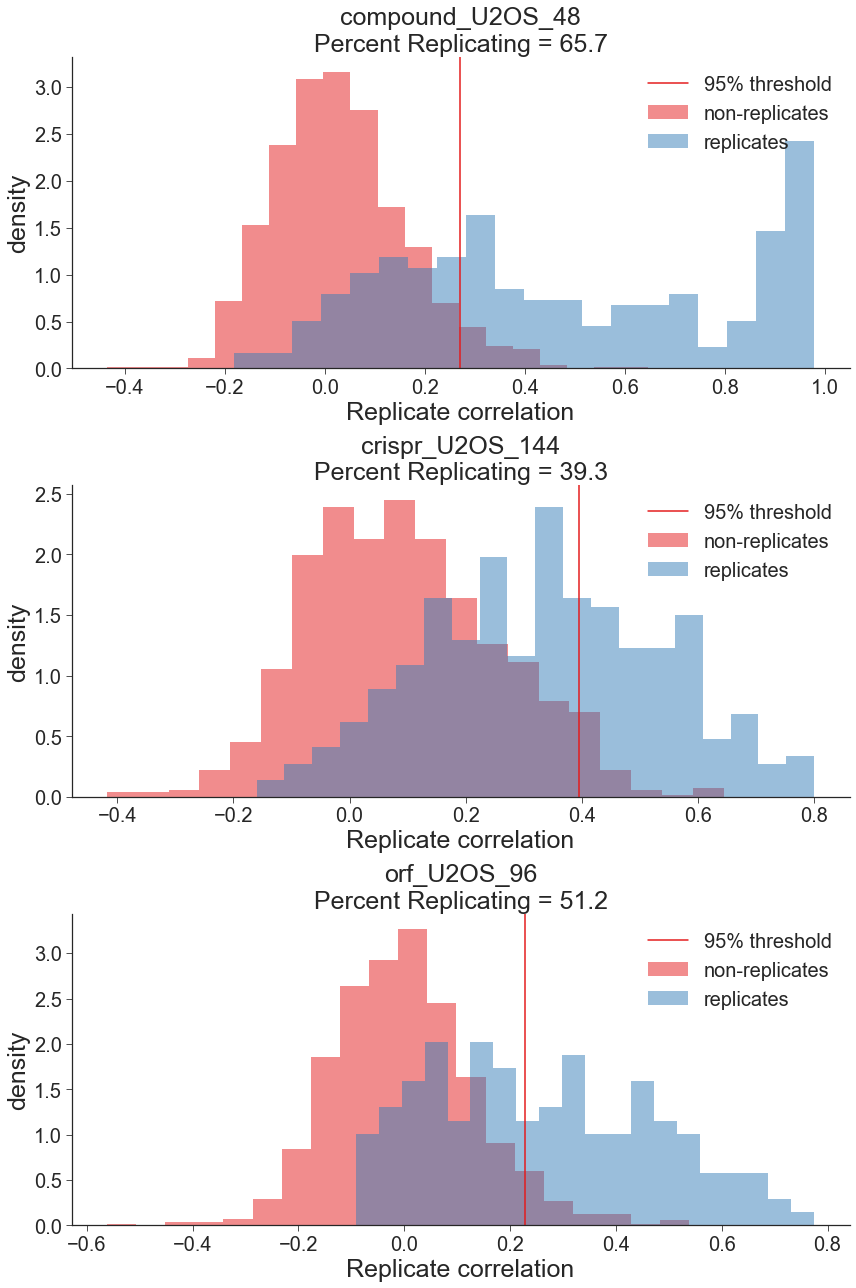

In [5]:
utils.distribution_plot(df=corr_replicating_df, output_file="4.percent_replicating.png", metric="Percent Replicating")

In [6]:
corr_replicating_df['Percent_Replicating'] = corr_replicating_df['Percent_Replicating'].astype(float)

corr_replicating_df.loc[(corr_replicating_df.Modality=='compound') & (corr_replicating_df.time=='48'), 'time'] = 'long'
corr_replicating_df.loc[(corr_replicating_df.Modality=='crispr') & (corr_replicating_df.time=='144'), 'time'] = 'long'
corr_replicating_df.loc[(corr_replicating_df.Modality=='orf') & (corr_replicating_df.time=='96'), 'time'] = 'long'

plot_corr_replicating_df = (
    corr_replicating_df.rename(columns={'Modality':'Perturbation'})
    .drop(columns=['Null_Replicating','Value_95','Replicating'])
)

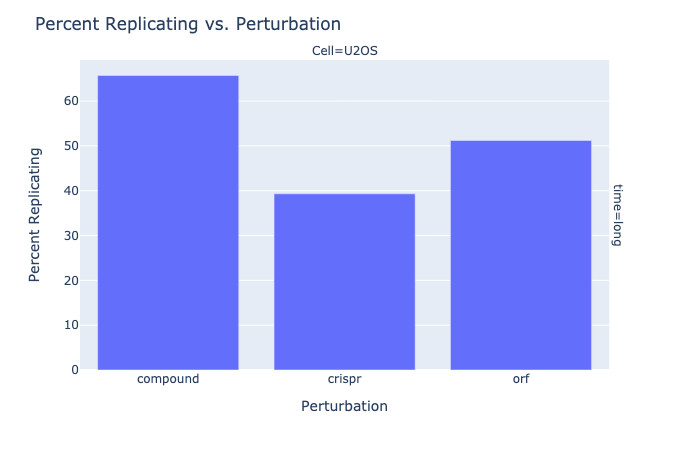

In [7]:
fig = px.bar(data_frame=plot_corr_replicating_df,
             x='Perturbation',
             y='Percent_Replicating',
             facet_row='time',
             facet_col='Cell')
fig.update_layout(title='Percent Replicating vs. Perturbation',
                  yaxis=dict(title='Percent Replicating'),
                  yaxis3=dict(title='Percent Replicating'))
fig.show("png")
fig.write_image(f'figures/4.percent_replicating_facet.png', width=640, height=480, scale=2)

In [8]:
print(plot_corr_replicating_df[['Description','Perturbation','time', 'Cell' ,'Percent_Replicating']].to_markdown(index=False))

| Description      | Perturbation   | time   | Cell   |   Percent_Replicating |
|:-----------------|:---------------|:-------|:-------|----------------------:|
| compound_U2OS_48 | compound       | long   | U2OS   |                  65.7 |
| crispr_U2OS_144  | crispr         | long   | U2OS   |                  39.3 |
| orf_U2OS_96      | orf            | long   | U2OS   |                  51.2 |


In [9]:
plot_corr_replicating_df['feature_set'] = 'DeepProfiler'
plot_corr_replicating_df.to_csv('output/deepprofiler_percent_replicating.csv', index=False)